# **Prédictions des années de plantations des arbres de Grenoble**

Bienvenue dans le notebook prédiction des années de plantations des arbres de Grenoble. Les données utilisées sont des informations recueillies sur les arbres plantés à Grenoble de ... 

## **Objectifs :**
- Analyser les données des arbres de Grenoble
- Construire plusieurs modèles de machine learning pour prédire les années de plantation de ces  arbres de Grenoble.
- Faire une évaluation robuste grâce à la cross validation.
- Améliorer leurs performances grâce à la Grid search
- Comparer ces modèles entre elles 

### Étape 1 : **Importation des modules requise pour l'étude**

In [1]:
import pandas as pd 
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_columns', None)

### Étape 2 : **Chargement des données** 

In [2]:
df_arbres = pd.read_csv("data/arbres_grenoble_epsg4326.csv")
df_arbres.head()

,elem_point_id,code,nom,genre,genre_desc,categorie,categorie_desc,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,adr_secteur,bien_reference,genre_bota,espece,variete,stadededeveloppement,equipe,remarques,anneedeplantation,raisondeplantation,traitementchenilles,courrier,identifiantplu,typeimplantationplu,intituleprotectionplu,anneeabattage,essouchement,diametrearbre,causeabattage,collectivite,stationmetro,hauteurarbre,portarbre,structure,forme,typenature,geo_point_2d
0,25301,ESP30399,AR30399,VEG,VEGETATION,ESP01,Arbre,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR30399,Pinus,nigra,Austriaca,Arbre adulte,NaN,fourche à 7 m,1975.0,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,"45.164519466065315,5.7364309029098335"
1,17909,ESP5185,AR5185,VEG,VEGETATION,ESP01,Arbre,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR5185,Pinus,nigra,Austriaca,Arbre adulte,NaN,dominé,1975.0,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,"45.16450876797978,5.736451624755175"
2,28960,ESP16027,AR16027,VEG,VEGETATION,ESP01,Arbre,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR16027,Pinus,nigra,Austriaca,Arbre adulte,NaN,NaN,1975.0,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,"45.164556703715526,5.736307688353201"
3,14246,ESP17702,AR17702,VEG,VEGETATION,ESP01,Arbre,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR17702,Pinus,nigra,Austriaca,Arbre adulte,NaN,NaN,1975.0,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,"45.164533444541846,5.736391508663688"
4,45677,ESP41299,AR41299,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP137,Sq Waldeck Rousseau,1,AR41299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.18330787379752,5.709045164969469"


### Étape 3 : **Prétraitement des données**

In [3]:
df_arbres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31895 entries, 0 to 31894
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   elem_point_id          31895 non-null  int64  
 1   code                   31895 non-null  object 
 2   nom                    31895 non-null  object 
 3   genre                  31895 non-null  object 
 4   genre_desc             31895 non-null  object 
 5   categorie              31895 non-null  object 
 6   categorie_desc         31895 non-null  object 
 7   sous_categorie         31895 non-null  object 
 8   sous_categorie_desc    31895 non-null  object 
 9   code_parent            31895 non-null  object 
 10  code_parent_desc       31895 non-null  object 
 11  adr_secteur            31895 non-null  int64  
 12  bien_reference         31895 non-null  object 
 13  genre_bota             31079 non-null  object 
 14  espece                 29415 non-null  object 
 15  va

##### *Variables chaines de caracteres: 28 colonnes*
##### *Variables Numerique: 10 colonnes dont 6 ne possedant aucunes informations*
##### *Total: 38 colonnes*


##### Suppression de colonnes non indispensables

Toutes les colonnnes dont le nombre total de valeurs manquantes sont  au dessus d'un certain seuil

On supprime toutes les colonnes ne possédant aucune informations ou possédant très peu d'informations

In [4]:
def high_nan_Columns_list(df, seuil):
    
    """Retourne une liste contenant des une proportion de valeur manquante superieur a un seuil."""
    
    return [elm for elm in df.columns if (df[elm].isna().sum()/df.shape[0])*100 >= seuil] 


list90nan = high_nan_Columns_list(df_arbres, 70)

# suppresion des  colonnes de plus de 90% de valeurs manquantes

df_arbres = df_arbres.drop(list90nan, axis = 1)

Maintenant Examinons le nombre valeurs uniques par colonnes

In [5]:
df_arbres.nunique()

elem_point_id           31895
code                    31895
nom                     31895
genre                       1
genre_desc                  1
categorie                   1
categorie_desc              1
sous_categorie              4
sous_categorie_desc         4
code_parent              1506
code_parent_desc         1506
adr_secteur                11
bien_reference          31895
genre_bota                120
espece                    292
stadededeveloppement        3
anneedeplantation          68
collectivite                2
hauteurarbre                3
portarbre                   7
structure                   4
typenature                  7
geo_point_2d            31895
dtype: int64

on supprime toute les colonnes qui n'ont qu'une seule valeurs unique, car ca ne nous apporte pas reellement d'information. 

In [6]:
df_arbres=df_arbres[df_arbres.columns[df_arbres.nunique()>1]]

In [7]:
print('Nombre restante de colonnes:',df_arbres.nunique().count())

Nombre restante de colonnes: 19


Observons maintenant les valeurs que contiennent chaque colonne. 

In [8]:
df_arbres

,elem_point_id,code,nom,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,adr_secteur,bien_reference,genre_bota,espece,stadededeveloppement,anneedeplantation,collectivite,hauteurarbre,portarbre,structure,typenature,geo_point_2d
0,25301,ESP30399,AR30399,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR30399,Pinus,nigra,Arbre adulte,1975.0,Ville de Grenoble,NaN,NaN,Ville de Grenoble,NaN,"45.164519466065315,5.7364309029098335"
1,17909,ESP5185,AR5185,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR5185,Pinus,nigra,Arbre adulte,1975.0,Ville de Grenoble,NaN,NaN,Ville de Grenoble,NaN,"45.16450876797978,5.736451624755175"
2,28960,ESP16027,AR16027,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR16027,Pinus,nigra,Arbre adulte,1975.0,Ville de Grenoble,NaN,NaN,Ville de Grenoble,NaN,"45.164556703715526,5.736307688353201"
3,14246,ESP17702,AR17702,ESP187,Bois semi naturel,ESP761,Grande pelouse butte des pins,6,AR17702,Pinus,nigra,Arbre adulte,1975.0,Ville de Grenoble,NaN,NaN,Ville de Grenoble,NaN,"45.164533444541846,5.736391508663688"
4,45677,ESP41299,AR41299,ESP174,Arbre d'espaces ouverts,ESP137,Sq Waldeck Rousseau,1,AR41299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.18330787379752,5.709045164969469"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31890,22630,ESP28052,AR28052,ESP151,Arbre de voirie,ESP1287,Bd J Vallier voie tram pair,1,AR28052,Liriodendron,tulipifera,Arbre jeune,2005.0,Grenoble Alpes Métropole,de 10 m à 20 m,Libre,Métropole de Grenoble,Libre,"45.180145884199455,5.708644349254183"
31891,22634,ESP28053,AR28053,ESP151,Arbre de voirie,ESP1287,Bd J Vallier voie tram pair,1,AR28053,Betula,verrucosa,Arbre jeune,2005.0,Grenoble Alpes Métropole,Moins de 10 m,Libre,Métropole de Grenoble,Libre,"45.18022983714377,5.712917076957194"
31892,22644,ESP28055,AR28055,ESP151,Arbre de voirie,ESP195,R Ampère ang Lindbergh,1,AR28055,Liquidambar,styraciflua,Arbre adulte,1989.0,Grenoble Alpes Métropole,NaN,NaN,Métropole de Grenoble,NaN,"45.18314214954124,5.705678144597991"
31893,22646,ESP28056,AR28056,ESP151,Arbre de voirie,ESP1288,R DrGreffier,1,AR28056,Acer,negundo,Arbre adulte,1996.0,Grenoble Alpes Métropole,Moins de 10 m,Semi-libre,Métropole de Grenoble,Semi-libre,"45.18164036492663,5.705245792013283"


In [9]:
df_arbres.nunique()

elem_point_id           31895
code                    31895
nom                     31895
sous_categorie              4
sous_categorie_desc         4
code_parent              1506
code_parent_desc         1506
adr_secteur                11
bien_reference          31895
genre_bota                120
espece                    292
stadededeveloppement        3
anneedeplantation          68
collectivite                2
hauteurarbre                3
portarbre                   7
structure                   4
typenature                  7
geo_point_2d            31895
dtype: int64

- Les colonnes code, nom,bien_reference sont des variables categorielles de 31895 classes. Ce qui veut dire que ces categories sont caracteristiques de chaque arbres, pas d'un groupe d'arbres.Les valeurs de cette variable commence par soit par 'ESP' ou par 'AR' et se termine par un nombre. Nous allons donc emputer la partie nom mumerique et ne garder que la partie numerique de ces colonnes. 

- Cependant les colonnes nom et code ont les memes nombre apres "AR" et 'ESP'. Donc nous allons supprimer l'une de ces colonnes(Je choisis la colonne 'nom'). La colonne 'bien_reference' est une copie de la colonne 'nom' donc elle sera elle aussi supprime.

- La variable 'code_parent' va aussi subir la numerisation de ces valeurs, c'est a dire qu'elle va etre transformer en variable quantitative.

- La colonne elem_point_id est une colonne categorielle mais numerique. Elle represente l'identite numerique de l'arbre, et est probablement associe a chaque arbre par ordre croissant. cette colonne est a conserver.


- Les colonnes Portarbre, collectivite, remarques, code_parent_desc (description du code parent), sous_categorie_desc(description de la sous categorie), raisondeplantation, typeimplantationplu, typenature, forme, sont a supprime:


In [10]:
def del_ESP(row):
    """Transforme les valeurs alphanumeriques de la colonne 'code' en valeur numerique """
    return int(row[3:])

df_arbres['code'] = df_arbres['code'].apply(del_ESP).apply(pd.to_numeric,errors = 'coerce')

In [11]:
df_arbres['code_parent'] = df_arbres['code_parent'].apply(del_ESP).apply(pd.to_numeric,errors = 'coerce')

In [12]:
colonne_a_supprimer = ['portarbre','typenature','collectivite','code_parent_desc','sous_categorie_desc','typenature','nom','bien_reference']

df_arbres = df_arbres.drop(colonne_a_supprimer, axis = 1)

In [13]:
df_arbres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31895 entries, 0 to 31894
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   elem_point_id         31895 non-null  int64  
 1   code                  31895 non-null  int64  
 2   sous_categorie        31895 non-null  object 
 3   code_parent           31895 non-null  int64  
 4   adr_secteur           31895 non-null  int64  
 5   genre_bota            31079 non-null  object 
 6   espece                29415 non-null  object 
 7   stadededeveloppement  27645 non-null  object 
 8   anneedeplantation     29756 non-null  float64
 9   hauteurarbre          20199 non-null  object 
 10  structure             31080 non-null  object 
 11  geo_point_2d          31895 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 2.9+ MB


On observe a nouveau le pourcentage de valeurs manquantes par colonne.

In [14]:
(df_arbres.isna().sum()/df_arbres.shape[0])*100

elem_point_id            0.000000
code                     0.000000
sous_categorie           0.000000
code_parent              0.000000
adr_secteur              0.000000
genre_bota               2.558395
espece                   7.775513
stadededeveloppement    13.324973
anneedeplantation        6.706380
hauteurarbre            36.670325
structure                2.555259
geo_point_2d             0.000000
dtype: float64

 Transformons la colonne geo_point_2d en deux colonnes, l'une pour la longitude et l'autre pour la latitude.

In [15]:
def longitude(x):
    return x.split(',')[1]
def latitude(x):
    return x.split(',')[0]

df_arbres['longitude'] = df_arbres['geo_point_2d'].apply(longitude).apply(pd.to_numeric,errors = 'coerce')
df_arbres['latitude'] = df_arbres['geo_point_2d'].apply(latitude).apply(pd.to_numeric,errors = 'coerce')

#supression de la colonne geo_point_2d
df_arbres = df_arbres.drop(['geo_point_2d'],axis = 1)

In [16]:
df_arbres.nunique()

elem_point_id           31895
code                    31895
sous_categorie              4
code_parent              1506
adr_secteur                11
genre_bota                120
espece                    292
stadededeveloppement        3
anneedeplantation          68
hauteurarbre                3
structure                   4
longitude               31894
latitude                31894
dtype: int64

#### Separation des donnees

notre objectif est de predire les annees de planttion des arbres qui n'en ont pas. pour cela nous allons enregistrer dans deux fichier differents les arbres qui en ont de ceux qui n'ent on pas.

In [17]:
# fichier des arbres sans annees de plantation
df_arbres[df_arbres['anneedeplantation'].isna() ==True].to_pickle("/home/moi/Téléchargements/Documents (2)/Machine_learning/arbres_sans_annees.pkl", protocol=4)

In [18]:
# fichier des arbres avec annees de plantation 
df_arbres[df_arbres['anneedeplantation'].isna() ==False].to_pickle("/home/moi/Téléchargements/Documents (2)/Machine_learning/arbres_avec_annees.pkl",protocol =4 )

###

#### Etude de la correlation entre les variables qualitatives

In [19]:
df_arbres = pd.read_pickle("/home/moi/Téléchargements/Documents (2)/Machine_learning/arbres_avec_annees.pkl")

def dependance_cat_val(contingence_tab,cat1,cat2):
    # defining the table
    stat, p, dof, expected = chi2_contingency(contingence_tab)
    # interpret p-value
    alpha = 0.08
    if p <= alpha:
	    print(f'{cat1} et {cat2} sont dependants(H0 rejetée) pvalue = {p}')
    else:
    	print(f'{cat1} et {cat2} sont independants(H0 acceptée) pvalue = {p}')

df_arbres_object = df_arbres.select_dtypes(include = object)
columns = df_arbres_object.columns
for i  in range(len(columns)):
    for j in range(i+1,len(columns)):
        contingence_tab = pd.crosstab(df_arbres_object[columns[i]],df_arbres_object[columns[j]])
        dependance_cat_val(contingence_tab,columns[i],columns[j])

sous_categorie et genre_bota sont dependants(H0 rejetée) pvalue = 0.0
sous_categorie et espece sont dependants(H0 rejetée) pvalue = 0.0
sous_categorie et stadededeveloppement sont dependants(H0 rejetée) pvalue = 8.198956510195815e-133
sous_categorie et hauteurarbre sont dependants(H0 rejetée) pvalue = 1.2295637611146827e-68
sous_categorie et structure sont dependants(H0 rejetée) pvalue = 0.0
genre_bota et espece sont dependants(H0 rejetée) pvalue = 0.0
genre_bota et stadededeveloppement sont dependants(H0 rejetée) pvalue = 0.0
genre_bota et hauteurarbre sont dependants(H0 rejetée) pvalue = 0.0
genre_bota et structure sont dependants(H0 rejetée) pvalue = 0.0
espece et stadededeveloppement sont dependants(H0 rejetée) pvalue = 0.0
espece et hauteurarbre sont dependants(H0 rejetée) pvalue = 0.0
espece et structure sont dependants(H0 rejetée) pvalue = 0.0
stadededeveloppement et hauteurarbre sont dependants(H0 rejetée) pvalue = 0.0
stadededeveloppement et structure sont dependants(H0 rejeté

On remarque que les variables qualitatives sont significativement dependants les uns des autres. Il faudrait donc en supprimer certains. nous allons effectuer observer la correlation entre ces variables avec la colonne 'Annees de plantations'.

Pour cela commencont par encoder ces variables avec le label encoding.

/home/moi/anaconda3/envs/mon_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,sous_categorie,genre_bota,espece,stadededeveloppement,hauteurarbre,structure,anneedeplantation
sous_categorie,1.000000,-0.117789,0.054245,-0.006954,0.050570,0.553770,-0.109485
genre_bota,-0.117789,1.000000,-0.081387,0.059907,-0.012080,-0.047942,0.016532
espece,0.054245,-0.081387,1.000000,0.081466,-0.054659,0.038715,0.154526
stadededeveloppement,-0.006954,0.059907,0.081466,1.000000,-0.150867,0.002851,0.532845
hauteurarbre,0.050570,-0.012080,-0.054659,-0.150867,1.000000,0.077690,-0.240560
structure,0.553770,-0.047942,0.038715,0.002851,0.077690,1.000000,-0.124400
anneedeplantation,-0.109485,0.016532,0.154526,0.532845,-0.240560,-0.124400,1.000000


<AxesSubplot:>

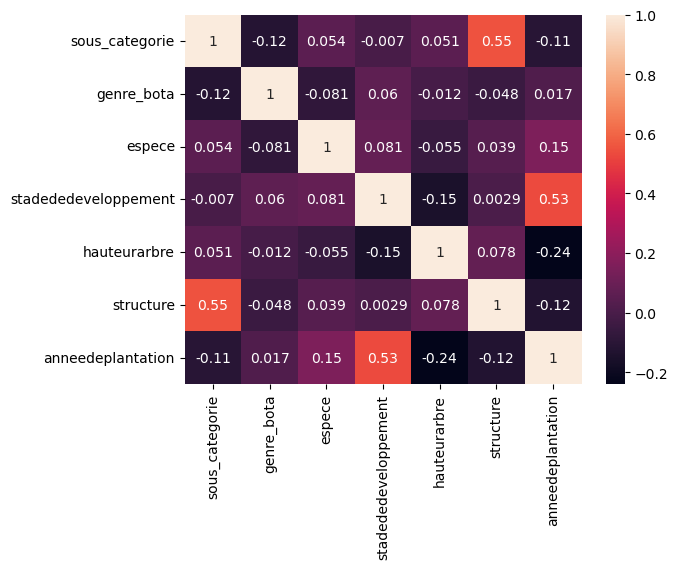

In [20]:
le = LabelEncoder()
for col in df_arbres_object.columns:
    le.fit(df_arbres_object[col])
    df_arbres_object[col]=le.transform(df_arbres_object[col])

df_arbres_object_annee_plantation = pd.concat([df_arbres_object, df_arbres[['anneedeplantation']]], axis = 1)
display(df_arbres_object_annee_plantation.corr())
sns.heatmap(df_arbres_object_annee_plantation.corr(),annot = True)



,elem_point_id,code,code_parent,adr_secteur,anneedeplantation,longitude,latitude
elem_point_id,1.000000,0.696476,0.320986,0.070798,0.446857,0.005302,0.031575
code,0.696476,1.000000,0.305788,0.054920,0.427472,-0.005507,0.068109
code_parent,0.320986,0.305788,1.000000,0.365135,0.114669,-0.019666,0.178623
adr_secteur,0.070798,0.054920,0.365135,1.000000,0.004116,0.161815,-0.062328
anneedeplantation,0.446857,0.427472,0.114669,0.004116,1.000000,-0.177962,0.026544
longitude,0.005302,-0.005507,-0.019666,0.161815,-0.177962,1.000000,0.043803
latitude,0.031575,0.068109,0.178623,-0.062328,0.026544,0.043803,1.000000


<AxesSubplot:>

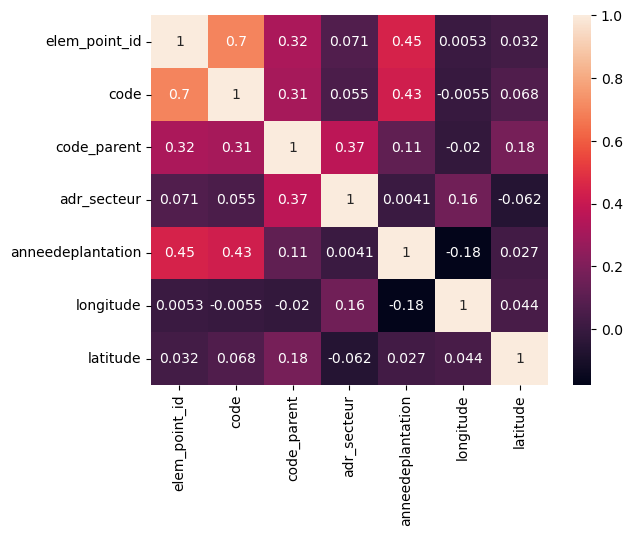

In [21]:
df_arbres_numeric = df_arbres.select_dtypes(include = np.number)
display(df_arbres_numeric.corr())
sns.heatmap(df_arbres_numeric.corr(),annot = True)